# Introduction
A very important aspect of supervised and semi-supervised machine learning is the quality of the labels produced by human labelers. Unfortunately, humans are not perfect and in some cases may even maliciously label things incorrectly. In this assignment, you will evaluate the impact of incorrect labels on a number of different classifiers.

We have provided a number of code snippets you can use during this assignment. Feel free to modify them or replace them.


## Dataset
The dataset you will be using is the [Adult Income dataset](https://archive.ics.uci.edu/ml/datasets/Adult). This dataset was created by Ronny Kohavi and Barry Becker and was used to predict whether a person's income is more/less than 50k USD based on census data.

### Data preprocessing
Start by loading and preprocessing the data. Remove NaN values, convert strings to categorical variables and encode the target variable (the string <=50K, >50K in column index 14).

In [1]:
import pandas as pd
import numpy as np

In [2]:
# This can be used to load the dataset
data = pd.read_csv("adult.csv", na_values='?').copy()
data.size

732630

In [3]:
data.dropna(axis=0, how="any", inplace=True)
data.size

678330

In [4]:
for column in data.columns:
    print(f'Values in column "{column}" are {data[column].unique()} of type {type(data[column][0])}')
    nan_count = data[column].isna().sum()
    empty_string_count = (data[column] == '').sum()
    placeholder_count = (data[column] == '?').sum()

    if nan_count > 0:
        print(f'NaN in column: {column}, count: {nan_count}')
    if empty_string_count > 0:
        print(f'Empty strings in column: {column}, count: {empty_string_count}')
    if placeholder_count > 0:
        print(f'Placeholder "?" in column: {column}, count: {placeholder_count}')
    if nan_count + empty_string_count + placeholder_count == 0:
        print(f'All empty or null values cells are cleaned for column {column}.')

Values in column "age" are [39 50 38 53 28 37 49 52 31 42 30 23 32 34 25 43 40 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 47 46 36 79 27 18 33 76 55 61 70 64 71 66 51 58
 26 17 60 90 75 65 77 62 63 67 74 72 69 68 73 81 78 88 80 84 83 85 82 86
 89 87] of type <class 'numpy.int64'>
All empty or null values cells are cleaned for column age.
Values in column "workclass" are ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov'
 'Self-emp-inc' 'Without-pay'] of type <class 'str'>
All empty or null values cells are cleaned for column workclass.
Values in column "fnlwgt" are [ 77516  83311 215646 ... 173449  89686 350977] of type <class 'numpy.int64'>
All empty or null values cells are cleaned for column fnlwgt.
Values in column "education" are ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 '7th-8th' 'Doctorate' 'Assoc-voc' 'Prof-school' '5th-6th' '10th'
 'Preschool' '12th' '1st-4th'] of type <class 'str'>
All empty or null values cells are cleaned

In [5]:
for column in data.columns:
    if column == "salary":
        data.loc[data['salary'] == '>50K', 'salary'] = 1
        data.loc[data['salary'] == '>50K.', 'salary'] = 1
        data.loc[data['salary'] == '<=50K', 'salary'] = 0
        data.loc[data['salary'] == '<=50K.', 'salary'] = 0
        data[column] = data[column].astype("int64")
    elif data[column].dtype == object:
        data[column] = data[column].astype("category")

In [6]:
data.dtypes

age                  int64
workclass         category
fnlwgt               int64
education         category
education-num        int64
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain         int64
capital-loss         int64
hours-per-week       int64
native-country    category
salary               int64
dtype: object

### Data classification
Choose at least 4 different classifiers and evaluate their performance in predicting the target variable. 

#### Preprocessing
Think about how you are going to encode the categorical variables, normalization, whether you want to use all of the features, feature dimensionality reduction, etc. Justify your choices 

A good method to apply preprocessing steps is using a Pipeline. Read more about this [here](https://machinelearningmastery.com/columntransformer-for-numerical-and-categorical-data/) and [here](https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf). 

<!-- #### Data visualization
Calculate the correlation between different features, including the target variable. Visualize the correlations in a heatmap. A good example of how to do this can be found [here](https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec). 

Select a features you think will be an important predictor of the target variable and one which is not important. Explain your answers. -->

#### Evaluation
Use a validation technique from the previous lecture to evaluate the performance of the model. Explain and justify which metrics you used to compare the different models. 

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler, StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt

numerical_features = data.drop('salary', axis=1).select_dtypes(include='int64').columns
categorical_features = data.select_dtypes(include='category').columns

# Define your preprocessing steps here
steps = [('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]

# Combine steps into a ColumnTransformer
ct = ColumnTransformer(transformers=steps)

# show the correlation between different features including target variable
def visualize(data, ct):
    X = data.drop('salary', axis=1)
    X_transformed = ct.fit_transform(X)
    X_transformed_dense = X_transformed.toarray()
    selector = SelectKBest(f_classif, k=40)
    X_selected = selector.fit_transform(X_transformed_dense, y)
    selected_indices = selector.get_support(indices=True)
    cat_feature_names = ct.named_transformers_['cat'].get_feature_names_out(categorical_features)
    feature_names = numerical_features.tolist() + cat_feature_names.tolist()
    selected_feature_names = [feature_names[i] for i in selected_indices]
    X_transformed_df = pd.DataFrame(X_selected, columns=selected_feature_names)
    X_transformed_df['salary'] = data['salary'].values
    correlation_matrix = X_transformed_df.corr()
    plt.figure(figsize=(14, 10))
    sns.set(font_scale=1.2) 
    heatmap = sns.heatmap(correlation_matrix, 
                          annot=False, 
                          cmap='RdBu', 
                          square=True, 
                          cbar_kws={"shrink": .8}, 
                          linewidths=.5, 
                          linecolor='black')  
    plt.title('Correlation Matrix', fontsize=20)
    plt.xticks(rotation=90, ha='right')  
    plt.yticks(rotation=0)  
    plt.tight_layout() 
    plt.show()

# Apply your model to feature array X and labels y
def apply_model(model, X, y):    
    # Wrap the model and steps into a Pipeline
    pipeline = Pipeline(steps=[('transformer', ct), 
                               ('feature_selection', SelectKBest(f_classif, k=20)),
                               ('model', model)])

    # Evaluate the model and store results
    return evaluate_model(X, y, pipeline)

# Apply your validation techniques and calculate metrics
def evaluate_model(X, y, pipeline):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    target_names = ["Less than 50k", "More than 50k"]
    report = classification_report(y_test, y_pred, target_names=target_names)
    
    return accuracy, report

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

models = [LogisticRegression(max_iter=500), SVC(C=1, kernel='linear', verbose=False, max_iter=-1), RandomForestClassifier(n_estimators=100, n_jobs=-1), KNeighborsClassifier()]
model_names = ["LR", "SVC" , "RFC", "KNN"]
for i, model in enumerate(models):
    X = data.drop('salary', axis=1)
    y = data['salary']
    acc, rep = apply_model(model, X, y)
    print(f'---------------------------------------------\n'
          f'Classifier {model_names[i]} \n'
          f'acc: {acc}\n'
          f'------\n'
          f'{rep}'
          f'------')

---------------------------------------------
Classifier LR 
acc: 0.843338861249309
------
               precision    recall  f1-score   support

Less than 50k       0.87      0.94      0.90      6745
More than 50k       0.75      0.57      0.65      2300

     accuracy                           0.84      9045
    macro avg       0.81      0.75      0.77      9045
 weighted avg       0.84      0.84      0.84      9045
------
---------------------------------------------
Classifier SVC 
acc: 0.841901603095633
------
               precision    recall  f1-score   support

Less than 50k       0.86      0.94      0.90      6745
More than 50k       0.76      0.56      0.64      2300

     accuracy                           0.84      9045
    macro avg       0.81      0.75      0.77      9045
 weighted avg       0.83      0.84      0.83      9045
------
---------------------------------------------
Classifier RFC 
acc: 0.8431177446102819
------
               precision    recall  f1-score  

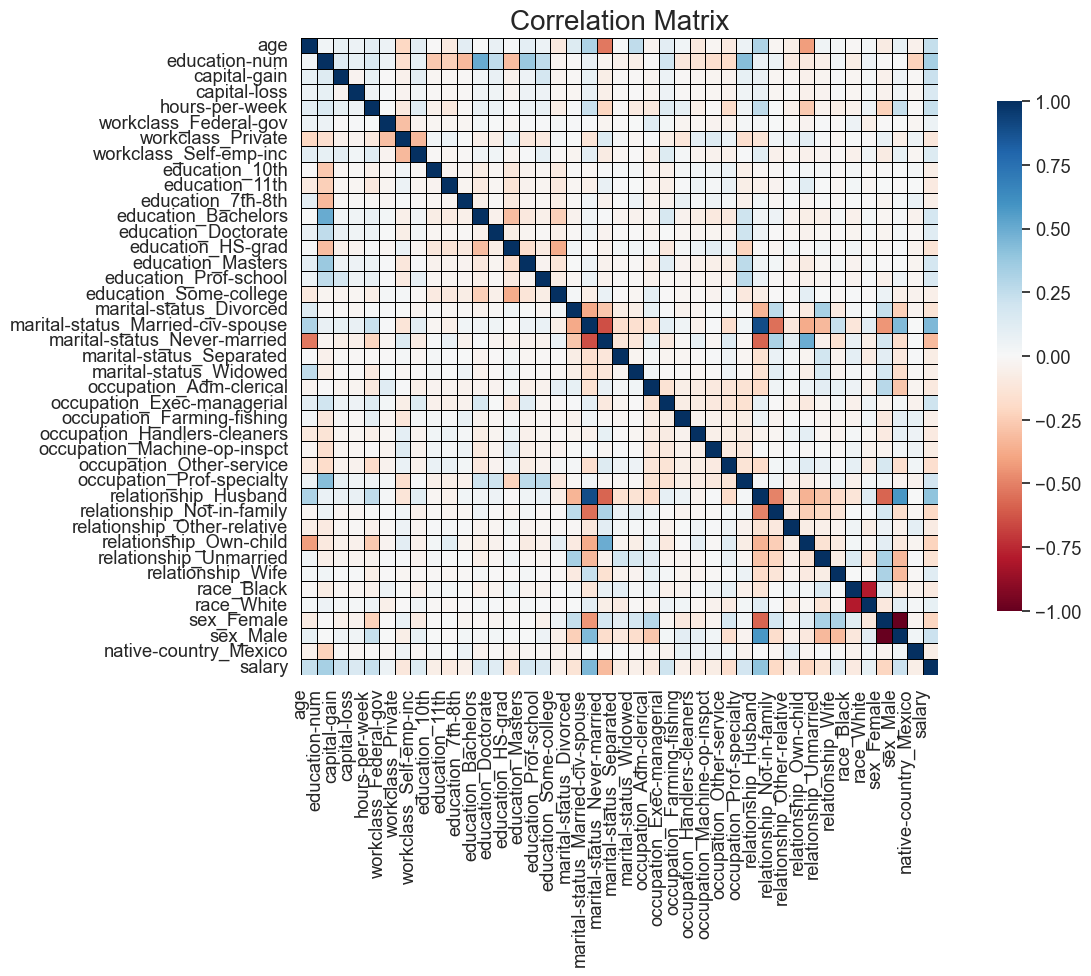

In [12]:
visualize(data, ct)

### Label perturbation
To evaluate the impact of faulty labels in a dataset, we will introduce some errors in the labels of our data.


#### Preparation
Start by creating a method which alters a dataset by selecting a percentage of rows randomly and swaps labels from a 0->1 and 1->0. 


In [13]:
"""Given a label vector, create a new copy where a random fraction of the labels have been flipped."""
def pertubate(y: np.ndarray, fraction: float) -> np.ndarray:
    perturbed_y = y.copy()
    random_indices = data.sample(n=int(fraction * len(perturbed_y)), random_state=1).index
    for i in random_indices:
        perturbed_y[i] = 1 - perturbed_y[i]
    return perturbed_y


In [14]:
models = [LogisticRegression(max_iter=500), SVC(C=1, kernel='linear', verbose=False, max_iter=-1), RandomForestClassifier(n_estimators=100, n_jobs=-1), KNeighborsClassifier()]
model_names = ["LR", "SVC" , "RFC", "KNN"]
for frac_number in [0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    print('-----------------------------------------------')
    print(f'Result for a fraction number of {frac_number}')
    for i, model in enumerate(models):
        X = data.drop('salary', axis=1)
        y_before = data['salary']
        y = pertubate(y_before, fraction=frac_number)
        acc, rep = apply_model(model, X, y)
        print(f'Classifier {model_names[i]} acc: {acc}')

-----------------------------------------------
Result for a fraction number of 0
Classifier LR acc: 0.843338861249309
Classifier SVC acc: 0.841901603095633
Classifier RFC acc: 0.840685461580984
Classifier KNN acc: 0.8223327805417358
-----------------------------------------------
Result for a fraction number of 0.1
Classifier LR acc: 0.7779988944168048
Classifier SVC acc: 0.7542288557213931
Classifier RFC acc: 0.7551133222775014
Classifier KNN acc: 0.74383637368712
-----------------------------------------------
Result for a fraction number of 0.2
Classifier LR acc: 0.703150912106136


KeyboardInterrupt: 

#### Analysis
Create a number of new datasets with perturbed labels, for fractions ranging from `0` to `0.5` in increments of `0.1`.

Perform the same experiment you did before, which compared the performances of different models except with the new datasets. Repeat your experiment at least 5x for each model and perturbation level and calculate the mean and variance of the scores. Visualize the change in score for different perturbation levels for all of the models in a single plot. 

State your observations. Is there a change in the performance of the models? Are there some classifiers which are impacted more/less than other classifiers and why is this the case?

In [ ]:
# Code

Observations + explanations: max. 400 words

#### Discussion

1)  Discuss how you could reduce the impact of wrongly labeled data or correct wrong labels. <br />
    max. 400 words



    Authors: Youri Arkesteijn, Tim van der Horst and Kevin Chong.


## Machine Learning Workflow

From part 1, you will have gone through the entire machine learning workflow which are they following steps:

1) Data Loading
2) Data Pre-processing
3) Machine Learning Model Training
4) Machine Learning Model Testing

You can see these tasks are very sequential, and need to be done in a serial fashion. 

As a small perturbation in the actions performed in each of the steps may have a detrimental knock-on effect in the task that comes afterwards.

In the final part of Part 1, you will have experienced the effects of performing perturbations to the machine learning model training aspect and the reaction of the machine learning model testing section.

## Part 2 Data Discovery

Now we have a some datasets that are related to each other.

**Altogether they are the same as the adult dataset used in the part 1 of the assignment.**

In this scenario, one can see the utility of the subsets of data can impact the outcome of the task from the previous section.

Because the data is split up, we want to be able to re-construct the data through data discovery.

As data discovery will allow you to be able to find relations that can be used to reconstruct the entire dataset.

Implement a method of your choice to perform the data discovery to be able to recover the entire dataset from part 1 of the assignment.

In [8]:
class FoundJoin(Exception): pass
class FoundUnion(Exception): pass

def discovery_algorithm(datasets):
    """Function should be able to perform data discovery to find related datasets
    Possible Input: List of datasets
    Output: List of pairs of related datasets
    """
    return join_algorithm(union_algorithm(datasets))

def join_algorithm(datasets, skip_datasets=None):
    """
    Algorithm that finds all datasets that are compatibly by join and returns
    a combined dataset.
    :param datasets: array of input datasets
    :param skip_datasets: indices of any dataset to skip
    :return: array of combined datasets
    """
    resulting_datasets = []
    skipped_datasets = []
    len_datasets = len(datasets)
    
    # Remove datasets that we don't want to union:
    if skip_datasets is not None:
        for to_skip in skip_datasets:
            skipped_datasets.append(datasets.remove(to_skip))
            
    for idx, dataset_1 in enumerate(datasets):
        # For each dataset, try to find another dataset to join on:
        merged_dataset = None
        try:
            for idx_2, dataset_2 in enumerate(datasets[idx + 1:]):
                for column_1 in dataset_1.columns:
                    for column_2 in dataset_2.columns:
                        if dataset_1[column_1].equals(dataset_2[column_2]):
                            merged_dataset = pd.merge(dataset_1, dataset_2, left_on=column_1, right_on=column_2)
                            datasets.pop(idx_2)
                            raise FoundJoin(dataset_2)
                        
        # We found a dataset with a column we can join on, 
        # add the merged dataset to resulting_datasets.
        except FoundJoin:
            resulting_datasets.append(merged_dataset)
            
        # Cannot find any dataset to join on, 
        # add the unmerged dataset to resulting_datasets.
        else:
            resulting_datasets.append(dataset_1)

    # Recursively check if we can merge further, only if we merged
    # datasets in this iteration.
    if len(resulting_datasets) == len_datasets:
        for skipped_dataset in skipped_datasets:
            resulting_datasets.append(skipped_dataset)

        return resulting_datasets
    else:
        recursion = join_algorithm(resulting_datasets)
        for skipped_dataset in skipped_datasets:
            recursion.append(skipped_dataset)

        return recursion
                        
def union_algorithm(datasets, skip_datasets=None, minimal_intersection=0.4):
    """
    Algorithm that finds all datasets that are compatibly by union and returns
    a combined dataset.
    :param datasets: array of input datasets
    :param skip_datasets: indices of any dataset to skip
    :param minimal_intersection: minimal percentage of headers that need to overlap
    to perform a union
    :return: array of combined datasets
    """
    resulting_datasets = []
    skipped_datasets = []
    len_datasets = len(datasets)
    
    # Remove datasets that we don't want to union:
    if skip_datasets is not None:
        for to_skip in skip_datasets:
            skipped_datasets.append(datasets.remove(to_skip))
    
    for idx, dataset_1 in enumerate(datasets):
        # For each dataset, try to find another dataset to union on:
        concatenated_dataset = None
        try:
            for idx_2, dataset_2 in enumerate(datasets[idx + 1:]):
                union_columns = len(set(dataset_1.columns).union(set(dataset_2.columns)))
                intersection_columns = len(set(dataset_1.columns).intersection(set(dataset_2.columns)))
                
                # If columns are minimally intersecting by minimal_intersection,
                # we can union the two datasets.
                if intersection_columns > union_columns * minimal_intersection:
                    concatenated_dataset = pd.concat([dataset_1, dataset_2])
                    datasets.pop(idx_2)
                    raise FoundUnion
                        
        # We found a dataset with a column we can join on, 
        # add the merged dataset to resulting_datasets.
        except FoundUnion:
            resulting_datasets.append(concatenated_dataset)
            datasets.pop(idx)
            
        # Cannot find any dataset to join on, 
        # add the unmerged dataset to resulting_datasets.
        else:
            resulting_datasets.append(dataset_1)
            

    if len(resulting_datasets) == len_datasets:
        for skipped_dataset in skipped_datasets:
            resulting_datasets.append(skipped_dataset)

        return resulting_datasets
    else:
        recursion = union_algorithm(resulting_datasets, minimal_intersection=minimal_intersection)
        for skipped_dataset in skipped_datasets:
            recursion.append(skipped_dataset)

        return recursion

def grab_data(x=3, y=2):
    """
    :param x: first digit of csv
    :param y: second digit of csv
    :return: array with all datasets
    """
    data_array = []
    for current_x in range(0, x):
        for current_y in range(1, y + 1):
            data_array.append(pd.read_csv(
                f"data_adult_discovery/data_adult_{current_x}_{current_y}.csv", na_values='?').copy())
    return data_array
    
split_data = grab_data()
combined_data = discovery_algorithm(split_data.copy())

print("Shape uncombined dataset(s):")
for i in split_data:
    print(i.shape)
    
print("Shape combined dataset(s):")
for i in combined_data:
    print(i.shape)

Shape uncombined dataset(s):
(16281, 11)
(16281, 10)
(16281, 11)
(16281, 10)
(16280, 11)
(16280, 10)
Shape combined dataset(s):
(65123, 18)


In [48]:
# Change the index if you want to train on different dataset in the array.
combined_dataset = combined_data[0].copy()
combined_dataset = combined_dataset.drop('Unnamed: 0', axis=1).drop("first_name", axis=1).drop("last_names", axis=1)

numerical_features = combined_dataset.drop('salary', axis=1).select_dtypes(include='float64').columns
categorical_features = combined_dataset.select_dtypes(include='object').columns

for column in categorical_features:
    combined_dataset[column] = combined_dataset[column].fillna(combined_dataset[column].mode()[0])
    
for column in numerical_features:
    combined_dataset[column] = combined_dataset[column].fillna(combined_dataset[column].median())

for column in combined_dataset.columns:
    if column in ["last_names", "first_name"]:
        combined_dataset.drop(column, axis=1)
    elif column == "salary":
        combined_dataset.loc[combined_dataset['salary'] == '>50K', 'salary'] = 1
        combined_dataset.loc[combined_dataset['salary'] == '>50K.', 'salary'] = 1
        combined_dataset.loc[combined_dataset['salary'] == '<=50K', 'salary'] = 0
        combined_dataset.loc[combined_dataset['salary'] == '<=50K.', 'salary'] = 0
        combined_dataset[column] = combined_dataset[column].astype("int64")
    elif combined_dataset[column].dtype == object:
        combined_dataset[column] = combined_dataset[column].astype("category")

print(combined_dataset)

       hours-per-week         occupation  capital-gain    relationship  \
0                20.0      Other-service           0.0   Not-in-family   
1                20.0              Sales           0.0       Own-child   
2                40.0  Handlers-cleaners           0.0  Other-relative   
3                30.0              Sales           0.0       Own-child   
4                56.0  Machine-op-inspct           0.0       Unmarried   
...               ...                ...           ...             ...   
16275            40.0    Exec-managerial           0.0         Husband   
16276            40.0  Machine-op-inspct           0.0       Own-child   
16277            40.0       Adm-clerical           0.0   Not-in-family   
16278            40.0       Adm-clerical           0.0       Own-child   
16279            40.0    Farming-fishing           0.0         Husband   

       education-num     sex         workclass  capital-loss  \
0                9.0    Male           Private 

In [53]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler, StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Define your preprocessing steps here
steps = [('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features.drop("salary"))
    ]

# Combine steps into a ColumnTransformer
ct = ColumnTransformer(transformers=steps)

# Apply your model to feature array X and labels y
def apply_model(model, X, y):    
    # Wrap the model and steps into a Pipeline
    pipeline = Pipeline(steps=[('transformer', ct), 
                               ('feature_selection', SelectKBest(f_classif, k=20)),
                               ('model', model)])

    # Evaluate the model and store results
    return evaluate_model(X, y, pipeline)

# Apply your validation techniques and calculate metrics
def evaluate_model(X, y, pipeline):
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(Xt_test)
    accuracy = accuracy_score(yt_test, y_pred)
    target_names = ["Less than 50k", "More than 50k"]
    report = classification_report(yt_test, y_pred, target_names=target_names)
    
    return accuracy, report

Xt = data.drop('salary', axis=1)
yt = data['salary']
_, Xt_test, _, yt_test = train_test_split(Xt, yt, test_size=0.2, random_state=6)

models = [LogisticRegression(max_iter=500), SVC(C=1, kernel='linear', verbose=False, max_iter=-1), RandomForestClassifier(n_estimators=100, n_jobs=-1), KNeighborsClassifier()]
model_names = ["LR", "SVC" , "RFC", "KNN"]

for i, model in enumerate(models):
    X = combined_dataset.drop("salary", axis=1)
    y = combined_dataset['salary']
    acc, rep = apply_model(model, X, y)
    print(f'---------------------------------------------\n'
          f'Classifier {model_names[i]} \n'
          f'acc: {acc}\n'
          f'------\n'
          f'{rep}'
          f'------')

ValueError: A given column is not a column of the dataframe

### Evaluation

Following the same workflow as Part 1 of the assignment, you will need to perform the steps once again.
This means that with the difference in setting, there has now been a change in the data loading portion of the workflow. 

<!-- While performing data discovery, one can check how having more data of different relations can effect the outcome of the downstream task. -->

As you perform the act of data discovery you will be piecing the data back together one by one by finding the relation between the datasets.

As you piece the data back together, the entire dataset will be available in varying portions.

Then using the different portions of available data, fit the models that were used previously, and examine the results when testing on the appropriate data from the testing samples.

*The dataset from part 1 can be treated as the groundtruth, so you can try and random sample from that dataset to produce the testing samples that can be used in this part.* 

***

One can also evaluate on the effect of incorrectness of data discovery.

Suppose what you have done for data discovery is correct, this means the relations that are found are correct.

What if you perform a perturbation on the relations between the files? 

This would mean the dataset will be incorrectly joined, do you think there will be an impact on the outcome of the model that will be trained and then tested on the groudtruth dataset?

What would the effect be on the downstream tasks as mentioned in the machine learning workflow such as data pre-processing, machine learning model training and testing?

This can be evaluated in the same way as above.

In [55]:
def grab_data_with_salary(x=3, y=2):
    """
    :param x: first digit of csv
    :param y: second digit of csv
    :return: array with all datasets
    """
    data_array = []
    for current_x in range(0, x):
        for current_y in range(1, y + 1):
            ds = pd.read_csv(f"data_adult_discovery/data_adult_{current_x}_{current_y}.csv", na_values='?').copy()
            if "salary" in ds:
                data_array.append(ds)
    return data_array

# Apply your model to feature array X and labels y
def apply_model_two(model, X, y):    
    # Wrap the model and steps into a Pipeline
    pipeline = Pipeline(steps=[('transformer', ct), 
                               ('feature_selection', SelectKBest(f_classif, k=20)),
                               ('model', model)])

    # Evaluate the model and store results
    return evaluate_model_two(X, y, pipeline)

# Apply your validation techniques and calculate metrics
def evaluate_model_two(X, y, pipeline):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    target_names = ["Less than 50k", "More than 50k"]
    report = classification_report(y_test, y_pred, target_names=target_names)
    
    return accuracy, report

datasets = grab_data_with_salary()

for dataset in datasets:
    numerical_features = dataset.drop('salary', axis=1).select_dtypes(include='float64').columns
    categorical_features = dataset.select_dtypes(include='object').columns
    
    # Define your preprocessing steps here
    steps = [('num', MinMaxScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features.drop("salary"))
        ]
    # Combine steps into a ColumnTransformer
    ct = ColumnTransformer(transformers=steps)

    for column in categorical_features:
        dataset[column] = dataset[column].fillna(dataset[column].mode()[0])
        
    for column in numerical_features:
        dataset[column] = dataset[column].fillna(dataset[column].median())
    
    for column in dataset.columns:
        if column in ["last_names", "first_name"]:
            dataset.drop(column, axis=1)
        elif column == "salary":
            dataset.loc[dataset['salary'] == '>50K', 'salary'] = 1
            dataset.loc[dataset['salary'] == '>50K.', 'salary'] = 1
            dataset.loc[dataset['salary'] == '<=50K', 'salary'] = 0
            dataset.loc[dataset['salary'] == '<=50K.', 'salary'] = 0
            dataset[column] = dataset[column].astype("int64")
        elif dataset[column].dtype == object:
            dataset[column] = dataset[column].astype("category")
    
    models = [LogisticRegression(max_iter=500), SVC(C=1, kernel='linear', verbose=False, max_iter=-1),
              RandomForestClassifier(n_estimators=100, n_jobs=-1), KNeighborsClassifier()]
    model_names = ["LR", "SVC", "RFC", "KNN"]

    for i, model in enumerate(models):
        X = dataset.drop("salary", axis=1)
        y = dataset['salary']
        acc, rep = apply_model_two(model, X, y)
        print(f'---------------------------------------------\n'
              f'Classifier {model_names[i]} \n'
              f'acc: {acc}\n'
              f'------\n'
              f'{rep}'
              f'------')

---------------------------------------------
Classifier LR 
acc: 0.8050353085661652
------
               precision    recall  f1-score   support

Less than 50k       0.82      0.95      0.88      2487
More than 50k       0.67      0.34      0.45       770

     accuracy                           0.81      3257
    macro avg       0.75      0.64      0.67      3257
 weighted avg       0.79      0.81      0.78      3257
------
---------------------------------------------
Classifier SVC 
acc: 0.802886091495241
------
               precision    recall  f1-score   support

Less than 50k       0.84      0.92      0.88      2487
More than 50k       0.62      0.43      0.51       770

     accuracy                           0.80      3257
    macro avg       0.73      0.67      0.69      3257
 weighted avg       0.79      0.80      0.79      3257
------
---------------------------------------------
Classifier RFC 
acc: 0.8041142155357691
------
               precision    recall  f1-score 

## Discussions

1)  Discuss the different effects of the results of the data discovery results on various downstream tasks in the machine learning workflow.
    As stated previously, this is effecting the data loading portion of the ML workflow.

2)  Discuss also what aspects need to be considered when performing data discovery and evaluating the results of data discovery.

Max. 400 words

The perturbations that performed for part 1 and 2 are all data quality issues.

3) Discuss on the effects of data quality and how you may attempt to identify and solve these issues?

<!-- For the set of considerations that you have outlined for the choice of data discovery methods, choose one and identify under this new constraint, how would you identify and resolve this problem? -->

Max 400 words